# Boilerplate

In [10]:
%%capture
%run ../hnk-dskit/boilerplate.ipynb

In [11]:
! pip install --quiet joblib
! apt-get update -q
! apt-get install -q -y --allow-unauthenticated swig
! pip --quiet install pyrfr
! pip --quiet install Cython
! pip --quiet install auto-sklearn

Get:1 http://security.ubuntu.com/ubuntu xenial-security InRelease [107 kB]
Get:2 http://ftp.us.debian.org/debian testing InRelease [154 kB]
Couldn't create tempfiles for splitting up /var/lib/apt/lists/partial/security.ubuntu.com_ubuntu_dists_xenial-security_InReleaseIgn:1 http://security.ubuntu.com/ubuntu xenial-security InRelease
Couldn't create tempfiles for splitting up /var/lib/apt/lists/partial/ftp.us.debian.org_debian_dists_testing_InReleaseIgn:2 http://ftp.us.debian.org/debian testing InRelease
Get:3 http://ftp.us.debian.org/debian testing/main Sources.diff/Index [27.9 kB]
Get:4 http://ftp.us.debian.org/debian testing/main Sources 2019-01-07-1408.21.pdiff [1,607 B]
Get:5 http://ftp.us.debian.org/debian testing/main Sources 2019-01-07-2011.10.pdiff [1,557 B]
Get:6 http://ftp.us.debian.org/debian testing/main Sources 2019-01-08-0210.13.pdiff [42.2 kB]
Get:6 http://ftp.us.debian.org/debian testing/main Sources 2019-01-08-0210.13.pdiff [42.2 kB]
Get:7 http://archive.ubuntu.com/ubun

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.special import boxcox1p, inv_boxcox, boxcox
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import warnings
import autosklearn.classification
from joblib import dump, load

warnings.filterwarnings("ignore")
sns.set()

# Data Preparation

In [4]:
#! unzip -d data data/all.zip 

Archive:  data/all.zip
replace data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
! head data/train.csv

Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

In [8]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [9]:
test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,15122,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,15123,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,15124,2709,24,17,0,0,2950,208,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15125,2706,29,19,0,0,2920,210,195,115,6404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
test['Cover_Type'] = None
raw_df = pd.concat([train,test])

In [11]:
getNA(raw_df)

,columns,dtype,na
0,Cover_Type,object,565892


In [12]:
basicInfo(raw_df)

('shape:', (581012, 56))
<class 'pandas.core.frame.DataFrame'>
Int64Index: 581012 entries, 0 to 565891
Data columns (total 56 columns):
Id                                    581012 non-null int64
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Wilderness_Area1                      581012 non-null int64
Wilderness_Area2                      581012 non-null int64
Wilderness_Area3                      581012 non-null int64
Wilderness_Area4        

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


## EDA

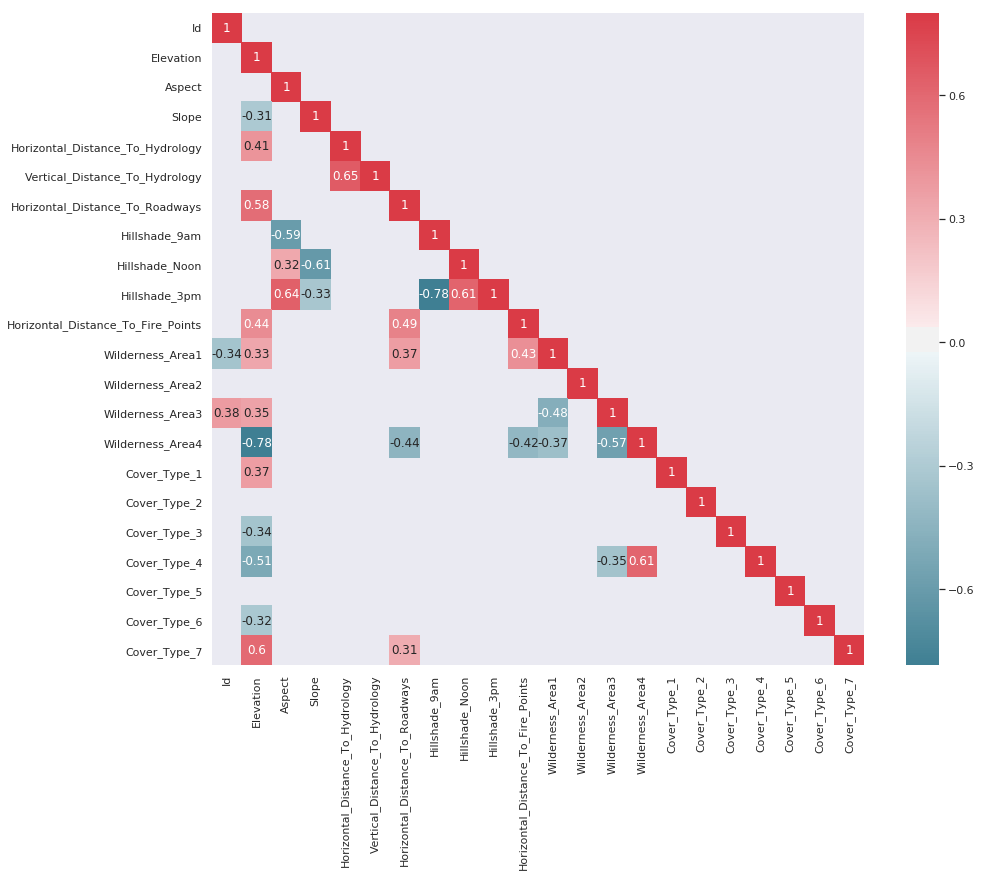

In [13]:
heatMap(pd.get_dummies(train, columns=['Cover_Type']).drop(['Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8','Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26','Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39','Soil_Type40'],axis=1),abs_cor=0.3 )

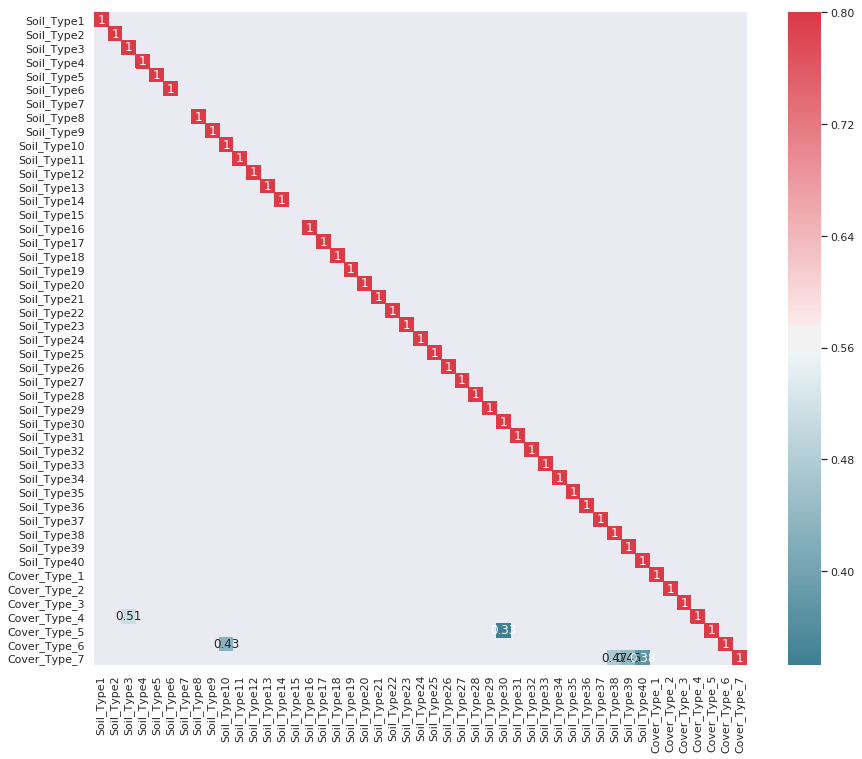

In [14]:
heatMap(
  pd.get_dummies(
    train[['Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8','Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26','Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39','Soil_Type40','Cover_Type']]
                 , columns=['Cover_Type'])
  ,abs_cor=0.3 )

In [15]:
raw_df.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,290506.500000,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,167723.861639,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1.000000,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,145253.750000,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,290506.500000,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

count    581012.000000
mean        155.656807
std         111.913721
min           0.000000
25%          58.000000
50%         127.000000
75%         260.000000
max         360.000000
Name: Aspect, dtype: float64
('Na percent:', 0)
('Skewness:', 0.4026283207718129)
('Kurtosis:', -1.220238942559293)


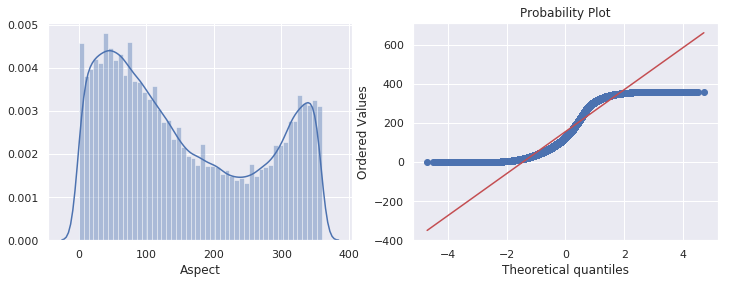

In [16]:
singleFieldAnalysis('Aspect',raw_df)

count    581012.000000
mean         14.103704
std           7.488242
min           0.000000
25%           9.000000
50%          13.000000
75%          18.000000
max          66.000000
Name: Slope, dtype: float64
('Na percent:', 0)
('Skewness:', 0.7892725471932496)
('Kurtosis:', 0.5811991100125318)


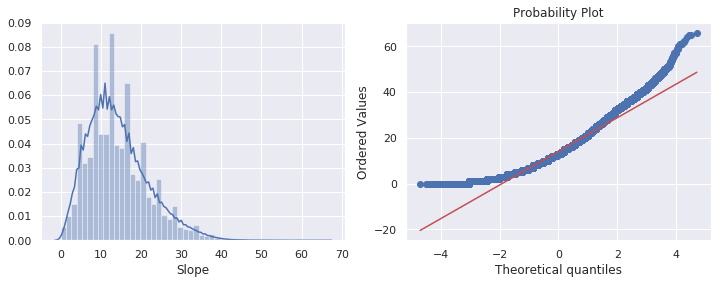

In [18]:
singleFieldAnalysis('Slope',raw_df)

count    581012.000000
mean       2959.365301
std         279.984734
min        1859.000000
25%        2809.000000
50%        2996.000000
75%        3163.000000
max        3858.000000
Name: Elevation, dtype: float64
('Na percent:', 0)
('Skewness:', -0.8175958182693059)
('Kurtosis:', 0.7492507754192657)


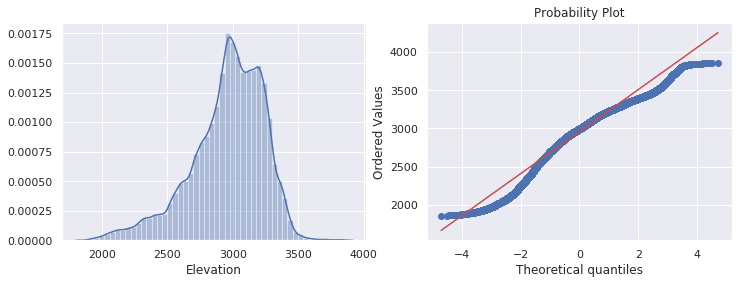

In [19]:
singleFieldAnalysis('Elevation',raw_df)

count    581012.000000
mean        212.146049
std          26.769889
min           0.000000
25%         198.000000
50%         218.000000
75%         231.000000
max         254.000000
Name: Hillshade_9am, dtype: float64
('Na percent:', 0)
('Skewness:', -1.18114666250383)
('Kurtosis:', 1.8755176645655212)


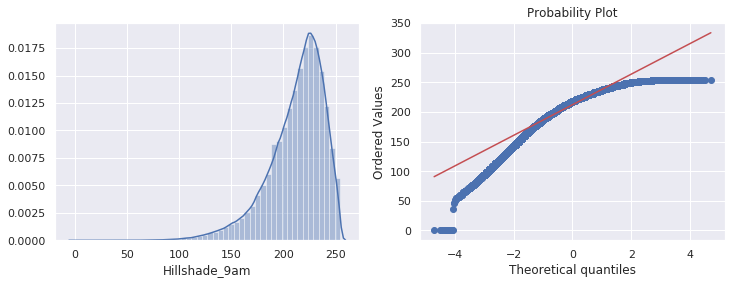

In [27]:
#Horizontal_Distance_To_Hydrology	Vertical_Distance_To_Hydrology	Horizontal_Distance_To_Roadways	Hillshade_9am	Hillshade_Noon	Hillshade_3pm	Horizontal_Distance_To_Fire_Points
singleFieldAnalysis('Hillshade_9am',raw_df)

count    581012.000000
mean        223.318716
std          19.768697
min           0.000000
25%         213.000000
50%         226.000000
75%         237.000000
max         254.000000
Name: Hillshade_Noon, dtype: float64
('Na percent:', 0)
('Skewness:', -1.0630562571520121)
('Kurtosis:', 2.0662108429586308)


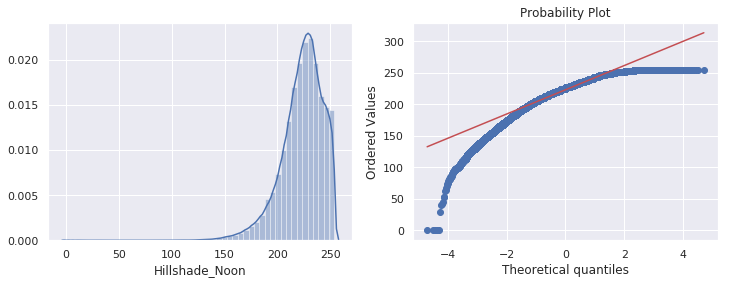

In [28]:
singleFieldAnalysis('Hillshade_Noon',raw_df)

count    581012.000000
mean        142.528263
std          38.274529
min           0.000000
25%         119.000000
50%         143.000000
75%         168.000000
max         254.000000
Name: Hillshade_3pm, dtype: float64
('Na percent:', 0)
('Skewness:', -0.27705319729498584)
('Kurtosis:', 0.39844001142700236)


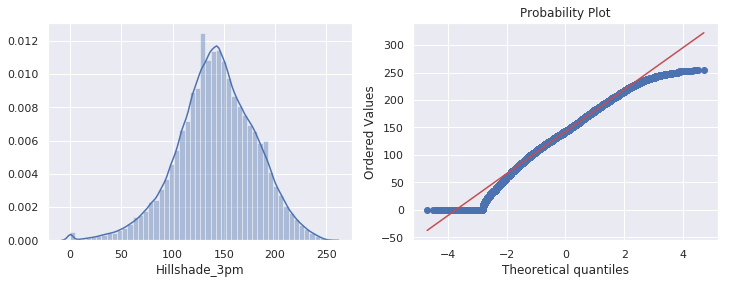

In [29]:
singleFieldAnalysis('Hillshade_3pm',raw_df)

count    581012.000000
mean       2350.146611
std        1559.254870
min           0.000000
25%        1106.000000
50%        1997.000000
75%        3328.000000
max        7117.000000
Name: Horizontal_Distance_To_Roadways, dtype: float64
('Na percent:', 0)
('Skewness:', 0.7136788231003839)
('Kurtosis:', -0.3837111911567752)


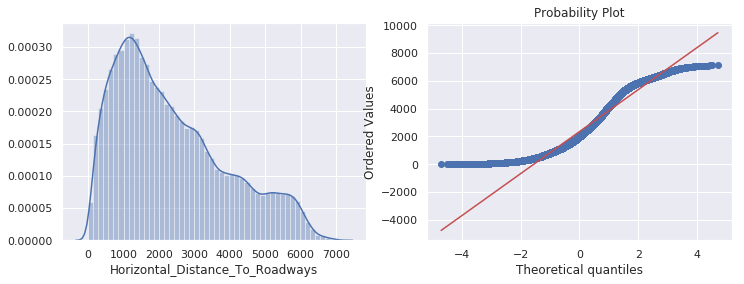

In [32]:
singleFieldAnalysis('Horizontal_Distance_To_Roadways',raw_df)

count    581012.000000
mean        269.428217
std         212.549356
min           0.000000
25%         108.000000
50%         218.000000
75%         384.000000
max        1397.000000
Name: Horizontal_Distance_To_Hydrology, dtype: float64
('Na percent:', 0)
('Skewness:', 1.140437391927878)
('Kurtosis:', 1.3661804988086468)


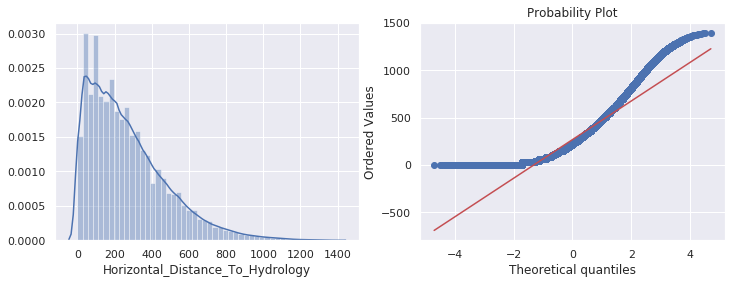

In [30]:
singleFieldAnalysis('Horizontal_Distance_To_Hydrology',raw_df)

count    581012.000000
mean         46.418855
std          58.295232
min        -173.000000
25%           7.000000
50%          30.000000
75%          69.000000
max         601.000000
Name: Vertical_Distance_To_Hydrology, dtype: float64
('Na percent:', 0)
('Skewness:', 1.790249745948561)
('Kurtosis:', 5.250295781112298)


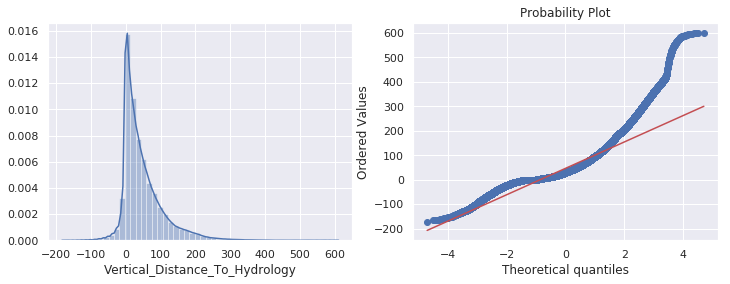

In [31]:
singleFieldAnalysis('Vertical_Distance_To_Hydrology',raw_df)

# Feature Engineering

In [6]:
# dump(raw_df, 'raw_df_feat_eng.joblib')
if not 'raw_df' in locals():
  raw_df = load('raw_df_feat_eng.joblib')

In [7]:
raw_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


## CV Check

In [8]:
def doSGDClassifierCV(feature, label, metrics="accuracy", cv_folds = 5):
  kf = KFold(
        cv_folds, shuffle=True, random_state=42
    ).get_n_splits(feature.values)
  score = cross_val_score(
      GradientBoostingClassifier(), feature.values, label.values, scoring=metrics, cv=kf
  )
  print("Score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [9]:
def doCV(df):
  train = df.dropna()
  doSGDClassifierCV(train.drop('Cover_Type',axis=1), train[['Cover_Type']].astype('int8'), metrics="accuracy", cv_folds = 5)

In [10]:
%%time
doCV(raw_df)

Score: 0.5396 (0.1151)
CPU times: user 1min 38s, sys: 101 ms, total: 1min 39s
Wall time: 1min 39s


In [34]:
def doFeatureImportance(df):
  train = df.dropna()
  model = GradientBoostingClassifier()
  feature = train.drop('Cover_Type',axis=1)
  model.fit(feature, train[['Cover_Type']].astype('int8'))
  
  coef = pd.Series(model.feature_importances_, index=feature.columns)
  print('Removed features:', coef[coef == 0].index)
  coef[coef != 0].sort_values().plot(kind="barh", figsize=(15, 12))
  plt.title("Coefficients in the Lasso Model")

Removed features: Index(['Soil_Type7', 'Soil_Type8', 'Soil_Type15', 'Soil_Type37'], dtype='object')


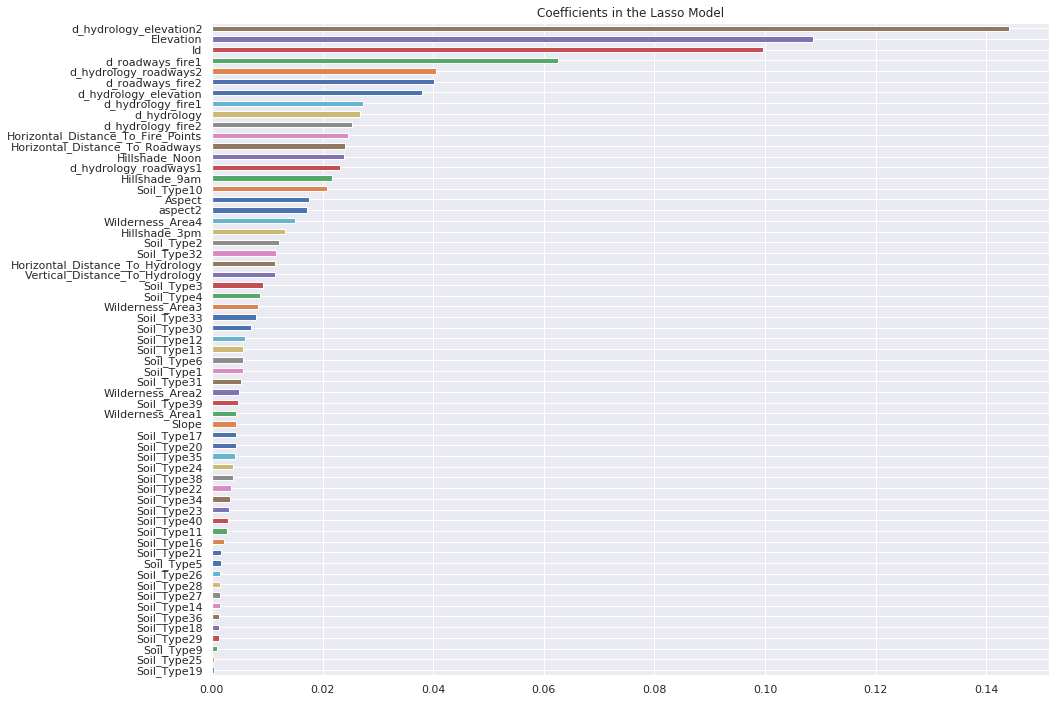

In [35]:
doFeatureImportance(raw_df)

## Aspect

In [11]:
raw_df['aspect2'] = np.where(raw_df['Aspect']>180,raw_df['Aspect']-180,raw_df['Aspect']+180 )

## Absolute Distance

In [12]:
raw_df['d_hydrology'] = np.sqrt(np.square(raw_df['Horizontal_Distance_To_Hydrology'])+np.square(raw_df['Vertical_Distance_To_Hydrology']) ) 		

## Horizontal Distance Interaction

In [13]:
raw_df['d_hydrology_roadways1'] = raw_df['Horizontal_Distance_To_Hydrology'] + raw_df['Horizontal_Distance_To_Roadways']
raw_df['d_hydrology_roadways2'] = np.abs(raw_df['Horizontal_Distance_To_Hydrology'] - raw_df['Horizontal_Distance_To_Roadways'])

raw_df['d_hydrology_fire1'] = raw_df['Horizontal_Distance_To_Hydrology'] + raw_df['Horizontal_Distance_To_Fire_Points']
raw_df['d_hydrology_fire2'] = np.abs(raw_df['Horizontal_Distance_To_Hydrology'] - raw_df['Horizontal_Distance_To_Fire_Points'])

raw_df['d_roadways_fire1'] = raw_df['Horizontal_Distance_To_Roadways'] + raw_df['Horizontal_Distance_To_Fire_Points']
raw_df['d_roadways_fire2'] = np.abs(raw_df['Horizontal_Distance_To_Roadways'] - raw_df['Horizontal_Distance_To_Fire_Points'])

## Vertical Distance Interaction

In [14]:
raw_df['d_hydrology_elevation'] = raw_df['Vertical_Distance_To_Hydrology'] + raw_df['Elevation']
raw_df['d_hydrology_elevation2'] = np.abs(raw_df['Vertical_Distance_To_Hydrology'] - raw_df['Elevation'])

## CV Check2

In [ ]:
%%time
doCV(raw_df)

# Modeling

In [4]:
# dump(raw_df, 'raw_df_model.joblib')
if not 'raw_df' in locals():
  raw_df = load('raw_df_model.joblib')

In [5]:
raw_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,aspect2,d_hydrology,d_hydrology_roadways1,d_hydrology_roadways2,d_hydrology_fire1,d_hydrology_fire2,d_roadways_fire1,d_roadways_fire2,d_hydrology_elevation,d_hydrology_elevation2
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,231,258.000000,768,252,6537,6021,6789,5769,2596,2596
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,236,212.084889,602,178,6437,6013,6615,5835,2584,2596
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,319,275.769832,3448,2912,6389,5853,9301,2941,2869,2739
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,335,269.235956,3332,2848,6453,5969,9301,3121,2903,2667
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,225,153.003268,544,238,6325,6019,6563,5781,2594,2596


In [6]:
wilderness_columns = ['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4']
soil_columns = ['Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8','Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26','Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39','Soil_Type40']

raw_df['Wilderness'] = raw_df[wilderness_columns].idxmax(axis=1).str.slice(15).astype('int8')
raw_df['Soil_Type'] = raw_df[soil_columns].idxmax(axis=1).str.slice(9).astype('int8')
raw_df.drop(wilderness_columns, axis=1, inplace=True)
raw_df.drop(soil_columns, axis=1, inplace=True)

In [7]:
raw_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,aspect2,d_hydrology,d_hydrology_roadways1,d_hydrology_roadways2,d_hydrology_fire1,d_hydrology_fire2,d_roadways_fire1,d_roadways_fire2,d_hydrology_elevation,d_hydrology_elevation2,Wilderness,Soil_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,5,231,258.000000,768,252,6537,6021,6789,5769,2596,2596,1,29
1,2,2590,56,2,212,-6,390,220,235,151,6225,5,236,212.084889,602,178,6437,6013,6615,5835,2584,2596,1,29
2,3,2804,139,9,268,65,3180,234,238,135,6121,2,319,275.769832,3448,2912,6389,5853,9301,2941,2869,2739,1,12
3,4,2785,155,18,242,118,3090,238,238,122,6211,2,335,269.235956,3332,2848,6453,5969,9301,3121,2903,2667,1,30
4,5,2595,45,2,153,-1,391,220,234,150,6172,5,225,153.003268,544,238,6325,6019,6563,5781,2594,2596,1,29


In [8]:
def model1():
    train = raw_df.dropna()
    feature = train.drop(['Id', 'Cover_Type'],axis = 1)
    label = train['Cover_Type'].astype('int8')
    feature_types = (['numerical']*20)+ (['categorical']*2)

    automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=3600*10,
        per_run_time_limit=3600,
        ml_memory_limit = 20000,
        ensemble_memory_limit=20000,
        output_folder='output',
        tmp_folder='temp',
        delete_output_folder_after_terminate=False,
        delete_tmp_folder_after_terminate=False,
        resampling_strategy = 'cv',
        resampling_strategy_arguments= {'folds':3},
        include_estimators= ['random_forest','extra_trees','k_nearest_neighbors','adaboost','gradient_boosting', 'libsvm_svc'],
        exclude_preprocessors = ['imputation']
    )
    automl.fit(feature, label, dataset_name='forest_cover_type',
               feat_type=feature_types)

    print(automl.show_models())
    dump(automl, 'model_cv.joblib')

In [ ]:
%%time
model1()

[WARNING] [2019-01-07 16:11:15,873:EnsembleBuilder(1):forest_cover_type] No models better than random - using Dummy Score!
[WARNING] [2019-01-07 16:11:15,939:EnsembleBuilder(1):forest_cover_type] No models better than random - using Dummy Score!
[WARNING] [2019-01-07 16:11:17,965:EnsembleBuilder(1):forest_cover_type] No models better than random - using Dummy Score!
[WARNING] [2019-01-07 16:11:19,995:EnsembleBuilder(1):forest_cover_type] No models better than random - using Dummy Score!
[WARNING] [2019-01-07 16:11:22,019:EnsembleBuilder(1):forest_cover_type] No models better than random - using Dummy Score!
[WARNING] [2019-01-07 16:11:24,038:EnsembleBuilder(1):forest_cover_type] No models better than random - using Dummy Score!
[WARNING] [2019-01-07 16:11:26,061:EnsembleBuilder(1):forest_cover_type] No models better than random - using Dummy Score!
[WARNING] [2019-01-07 16:11:28,084:EnsembleBuilder(1):forest_cover_type] No models better than random - using Dummy Score!
[WARNING] [2019-

## Retrain with all data

In [13]:
final_model = load('model_cv.joblib')

In [14]:
def retrain(model):
    train = raw_df.dropna()
    feature = train.drop(['Id', 'Cover_Type'],axis = 1)
    label = train['Cover_Type'].astype('int8')
    return model.refit(feature,label)

In [15]:
%%time
final_model2 = retrain(final_model)

CPU times: user 37min 21s, sys: 4.06 s, total: 37min 25s
Wall time: 36min 3s


In [16]:
dump(final_model2, 'model_cv2.joblib')

['model_cv2.joblib']

# Finish Up

In [6]:
final_model2 = load('model_cv2.joblib')

In [20]:
def predict(model, raw_df):
  test_feature = raw_df[raw_df['Cover_Type'].isna()]
  ans=None
  for i in range(0,math.ceil(test_feature.shape[0]/10000)):
    print(i)
    temp = model.predict(test_feature.drop(['Id', 'Cover_Type'],axis = 1).iloc[i*10000:(i*10000)+10000])
    if ans is None:
      ans = temp
    else:
      ans = np.concatenate([ans,temp])
  return ans

In [21]:
%%time
ans = predict(final_model2, raw_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
CPU times: user 1h 18min 49s, sys: 4.07 s, total: 1h 18min 53s
Wall time: 1h 17min 13s


In [22]:
test_feature = raw_df[raw_df['Cover_Type'].isna()]
test_feature['Cover_Type'] = ans
test_feature[['Id','Cover_Type']].to_csv('prediction3.csv', index=False)

In [23]:
! head prediction3.csv

Id,Cover_Type
15121,1
15122,1
15123,1
15124,1
15125,1
15126,1
15127,1
15128,1
15129,1


In [24]:
final_model2.get_models_with_weights()

[(0.14,
  SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'preprocessor:feature_agglomeration:pooling_func': 'mean', 'classifier:__choice__': 'libsvm_svc', 'categorical_encoding:__choice__': 'one_hot_encoding', 'preprocessor:feature_agglomeration:linkage': 'complete', 'preprocessor:__choice__': 'feature_agglomeration', 'classifier:libsvm_svc:C': 1.772947230488284, 'classifier:libsvm_svc:tol': 6.58869648864534e-05, 'preprocessor:feature_agglomeration:affinity': 'cosine', 'classifier:libsvm_svc:kernel': 'rbf', 'categorical_encoding:one_hot_encoding:minimum_fraction': 0.002385546176068135, 'categorical_encoding:one_hot_encoding:use_minimum_fraction': 'True', 'classifier:libsvm_svc:max_iter': -1, 'classifier:libsvm_svc:shrinking': 'True', 'classifier:libsvm_svc:gamma': 0.0004789329856033374, 'rescaling:__choice__': 'none', 'preprocessor:feature_agglomeration:n_clusters': 177, 'imputation:strategy': 'mean'},
  dataset_properties={
    'task': 2,
    'multiclass': True,
    

In [25]:
print(final_model2.sprint_statistics())

auto-sklearn results:
  Dataset name: forest_cover_type
  Metric: accuracy
  Best validation score: 0.887169
  Number of target algorithm runs: 55
  Number of successful target algorithm runs: 49
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 0

